In [20]:
import torch
import numpy as np
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans

device = torch.device('cpu')
print(device)

cpu


In [13]:
class LSH:
    def __init__(self, num_planes, vec_dimension):
        self.num_planes = num_planes
        self.vec_dimension = vec_dimension
        self.hyperplanes = np.random.randn(self.num_planes, self.vec_dimension)
        self.hash_buckets = {}
    
    def hash(self, vector):
        """Generate binary hash code for a given vector."""
        return (np.dot(self.hyperplanes, vector) > 0).astype(int)
    
    def fit(self, vec_dataset):
        """Fit the dataset to hash buckets."""
        self.dataset = vec_dataset
        self.hash_codes = np.array([self.hash(v) for v in vec_dataset])
        
        for idx, code in enumerate(self.hash_codes):
            code_tuple = tuple(code)
            self.hash_buckets.setdefault(code_tuple, []).append(idx)
    
    def get_bucket_sizes(self):
        """Return sizes of all hash buckets."""
        return [len(indices) for indices in self.hash_buckets.values()]
    
    def search(self, query_vec, neighbors_k=5):
        """Search for approximate nearest neighbors."""
        query_hash_tuple = tuple(self.hash(query_vec))
        candidate_indices = self.hash_buckets.get(query_hash_tuple, [])
        comparison_count = len(candidate_indices)
        
        if len(candidate_indices) < neighbors_k:
            all_indices = list(range(len(self.hash_codes)))
            additional_candidates = [i for i in all_indices if i not in candidate_indices]
            needed = neighbors_k - len(candidate_indices)
            candidate_indices.extend(additional_candidates[:needed])
            comparison_count += len(additional_candidates[:needed])
        
        if candidate_indices:
            dist_array = np.array([
                np.sum(self.hash_codes[idx] != query_hash_tuple)
                for idx in candidate_indices
            ])
            nearest_local_idx = np.argsort(dist_array)[:neighbors_k]
            return np.array(candidate_indices)[nearest_local_idx], comparison_count
        
        return np.array([]), comparison_count

def compute_metrics(train_vecs, train_labels, test_vecs, test_labels, neighbors_k=5):
    """Compute MRR, Precision@K, Hit Rate@K, and average comparisons."""
    lsh = LSH(num_planes=15, vec_dimension=train_vecs.shape[1])
    lsh.fit(train_vecs)
    
    mrr_total, precision_total, hit_total, total_comps = 0, 0, 0, 0
    total_queries = len(test_vecs)
    
    for q_vec, q_lbl in zip(test_vecs, test_labels):
        retrieved_idx, comps = lsh.search(q_vec, neighbors_k)
        if not len(retrieved_idx):
            continue
        
        ret_lbls = train_labels[retrieved_idx]
        rank = np.where(ret_lbls == q_lbl)[0]
        
        if rank.size > 0:
            mrr_total += 1 / (rank[0] + 1)
        
        precision_total += np.sum(ret_lbls == q_lbl) / neighbors_k
        hit_total += int(np.sum(ret_lbls == q_lbl) > 0)
        total_comps += comps
    
    return (
        mrr_total / total_queries,
        precision_total / total_queries,
        hit_total / total_queries,
        total_comps / total_queries,
    )


In [ ]:

def load_data():
    # Use map_location to load the tensors onto the CPU
    train_emb = torch.load("Dataset/train_embeddings.pth", map_location=device)
    train_lbl = torch.load("Dataset/train_labels.pth", map_location=device)
    test_emb = torch.load("Dataset/test_embeddings.pth", map_location=device)
    test_lbl = torch.load("Dataset/test_labels.pth", map_location=device)
    text_emb = torch.load("Dataset/text_embedding.pth", map_location=device)
    return train_emb, train_lbl, test_emb, test_lbl, text_emb

train_emb, train_lbl, test_emb, test_lbl, text_emb = load_data()

# Convert tensors to numpy arrays on CPU
train_emb = train_emb.cpu().numpy()
train_lbl = train_lbl.cpu().numpy()
test_emb = test_emb.cpu().numpy()
test_lbl = test_lbl.cpu().numpy()
text_emb = text_emb.cpu().numpy()


Train embeddings shape: (50000, 512)
Test embeddings shape: (10000, 512)


/var/folders/sc/2gy2r1nj7_l7l696dz517r280000gn/T/ipykernel_18830/3161314125.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_emb = torch.load("Dataset/train_embeddi

In [ ]:
def knn_lookup(train_vecs, query_vecs, neighbors_k, dist_metric="euclidean", return_comparisons=False):
    if dist_metric == "euclidean":
        distances = cdist(query_vecs, train_vecs, metric='euclidean')
    elif dist_metric == "cosine":
        distances = cdist(query_vecs, train_vecs, metric='cosine')


    neighbors_idx = np.argsort(distances, axis=1)[:, :neighbors_k]
    num_comparisons = len(train_vecs)

    if return_comparisons:
        return neighbors_idx, num_comparisons
    return neighbors_idx

def classify(train_vecs, train_lbls, test_vecs, test_lbls, neighbors_k, dist_metric="euclidean", n_jobs=-1):
    knn_indices = knn_lookup(train_vecs, test_vecs, neighbors_k, dist_metric)
    
    def predict(i):
        return np.bincount(train_lbls[knn_indices[i]]).argmax() == test_lbls[i]
    
    results = Parallel(n_jobs=n_jobs)(delayed(predict)(i) for i in range(len(test_lbls)))
    return np.mean(results)

In [9]:
k_values = [1, 5, 10]
distance_metrics = ["euclidean", "cosine"]

for kv in k_values:
    for distm in distance_metrics:
        acc = classify(train_emb, train_lbl, test_emb, test_lbl, kv, distm)
        print(f"Accuracy is {acc:.4f} for K={kv} with used distance Metric={distm}")
        print("--**--" * 10)

K=1, Metric=euclidean, Accuracy=0.9048
K=1, Metric=cosine, Accuracy=0.9048
K=5, Metric=euclidean, Accuracy=0.9182
K=5, Metric=cosine, Accuracy=0.9182
K=10, Metric=euclidean, Accuracy=0.9194
K=10, Metric=cosine, Accuracy=0.9194


In [10]:
def classify_text_vecs(text_vecs, test_vecs, test_lbls, neighbors_k=1, dist_metric="euclidean"):
    total_samples = len(test_lbls)
    correct_predictions = 0
    predicted_labels = []
    true_labels = []

    nearest_neighbors = knn_lookup(text_vecs, test_vecs, neighbors_k, dist_metric)
    
    for i in range(total_samples):
        predicted_label = nearest_neighbors[i][0]
        true_label = test_lbls[i]
        
        predicted_labels.append(predicted_label)
        true_labels.append(true_label)
        
        if predicted_label == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / total_samples
    return accuracy

for distm in distance_metrics:
    acc_text = classify_text_vecs(
        text_emb, test_emb, test_lbl, neighbors_k=1, dist_metric=distm
    )
    print(f"Accuracy is {acc_text:.4f} for K=1 with used distance Metric={distm}")
    print("--**--" * 10)

Accuracy is 0.8781 for K=1 with used distance Metric=euclidean
--**----**----**----**----**----**----**----**----**----**--
Accuracy is 0.8781 for K=1 with used distance Metric=cosine
--**----**----**----**----**----**----**----**----**----**--


In [11]:
def mean_reciprocal_rank(retrieved_indices, query_labels, target_labels):
    """
    Compute Mean Reciprocal Rank (MRR) for retrieval results.
    """
    mrr_sum = 0.0
    for i, retrieved in enumerate(retrieved_indices):
        for rank, idx in enumerate(retrieved):
            if target_labels[idx] == query_labels[i]:
                mrr_sum += 1.0 / (rank + 1)
                break
    return mrr_sum / len(retrieved_indices)

def precision_at_k(retrieved_indices, query_labels, target_labels, k=100):
    """
    Compute Precision@K for retrieval results.
    """
    precision_sum = 0.0
    for i, retrieved in enumerate(retrieved_indices):
        relevant_count = sum(1 for idx in retrieved[:k] if target_labels[idx] == query_labels[i])
        precision_sum += relevant_count / k
    return precision_sum / len(retrieved_indices)

def hit_rate_at_k(retrieved_indices, query_labels, target_labels, k=100):
    """
    Compute Hit Rate@K for retrieval results.
    """
    hit_count = sum(
        1 for i, retrieved in enumerate(retrieved_indices)
        if any(target_labels[idx] == query_labels[i] for idx in retrieved[:k])
    )
    return hit_count / len(retrieved_indices)

def text_to_image_retrieval(train_vectors, train_labels, query_vectors, neighbors_k=100, dist_metric="euclidean"):
    """
    Perform text-to-image retrieval evaluation using MRR, Precision@K, and Hit Rate@K.
    """
    query_labels = np.arange(len(query_vectors))
    retrieved_indices = knn_lookup(train_vectors, query_vectors, neighbors_k, dist_metric)
    
    target_labels = np.array(train_labels)
    
    mrr = mean_reciprocal_rank(retrieved_indices, query_labels, target_labels)
    precision = precision_at_k(retrieved_indices, query_labels, target_labels, neighbors_k)
    hit_rate = hit_rate_at_k(retrieved_indices, query_labels, target_labels, neighbors_k)
    
    return mrr, precision, hit_rate

# Run retrieval evaluation
mrr_score, precision_score, hit_rate_score = text_to_image_retrieval(train_emb, train_lbl, text_emb, neighbors_k=100)

# Display results
print(f"MRR is {mrr_score:.4f}")
print(f"Precision is {precision_score:.4f}")
print(f"Hit Rate is {hit_rate_score:.4f}")
print("--**--" * 10)

MRR is 1.0000
Precision is 0.9740
Hit Rate is 1.0000
--**----**----**----**----**----**----**----**----**----**--


In [12]:
def image_to_image_retrieval(train_vectors, train_labels, test_vectors, test_labels, neighbors_k=100, n_jobs=-1):
    """
    Perform image-to-image retrieval evaluation using MRR, Precision@K, and Hit Rate@K.
    """
    nn_indices, avg_comparisons = knn_lookup(train_vectors, test_vectors, neighbors_k, return_comparisons=True)
    
    def compute_metrics(index):
        """Compute MRR, Precision@K, and Hit Rate@K for a single query."""
        query_label = [test_labels[index]]
        retrieved_indices = [nn_indices[index]]
        
        mrr = mean_reciprocal_rank(retrieved_indices, query_label, train_labels)
        precision = precision_at_k(retrieved_indices, query_label, train_labels, neighbors_k)
        hit_rate = hit_rate_at_k(retrieved_indices, query_label, train_labels, neighbors_k)
        
        return mrr, precision, hit_rate
    
    # Compute metrics in parallel
    results = Parallel(n_jobs=n_jobs)(delayed(compute_metrics)(i) for i in range(len(test_labels)))
    
    # Aggregate results
    mrr_score = np.mean([res[0] for res in results])
    precision_score = np.mean([res[1] for res in results])
    hit_rate_score = np.mean([res[2] for res in results])
    
    return mrr_score, precision_score, hit_rate_score, avg_comparisons

# Run retrieval evaluation
mrr_score, precision_score, hit_rate_score, avg_comparisons = image_to_image_retrieval(
    train_emb, train_lbl, test_emb, test_lbl, neighbors_k=100
)

# Display results
print(f"MRR is {mrr_score:.4f}")
print(f"Precision is {precision_score:.4f}")
print(f"Hit Rate is {hit_rate_score:.4f}")
print(f"Average Comparisons per Query: {avg_comparisons}")
print("--**--" * 10)


MRR is 0.9348
Precision is 0.8411
Hit Rate is 0.9996
Average Comparisons per Query: 50000
--**----**----**----**----**----**----**----**----**----**--


In [14]:
k = 100
mrr_lsh, prec_lsh, hit_lsh, avg_comps_lsh = compute_metrics(
    train_emb, train_lbl, test_emb, test_lbl, k
)

print(f"MRR is {mrr_lsh:.4f}")
print(f"Precision is {prec_lsh:.4f}")
print(f"Hit Rate is {hit_lsh:.4f}")
print(f"Average Comparisons per Query: {avg_comps_lsh}")
print("--**--" * 10)


MRR is 0.6013
Precision is 0.3023
Hit Rate is 0.9950
Average Comparisons per Query: 225.9646
--**----**----**----**----**----**----**----**----**----**--


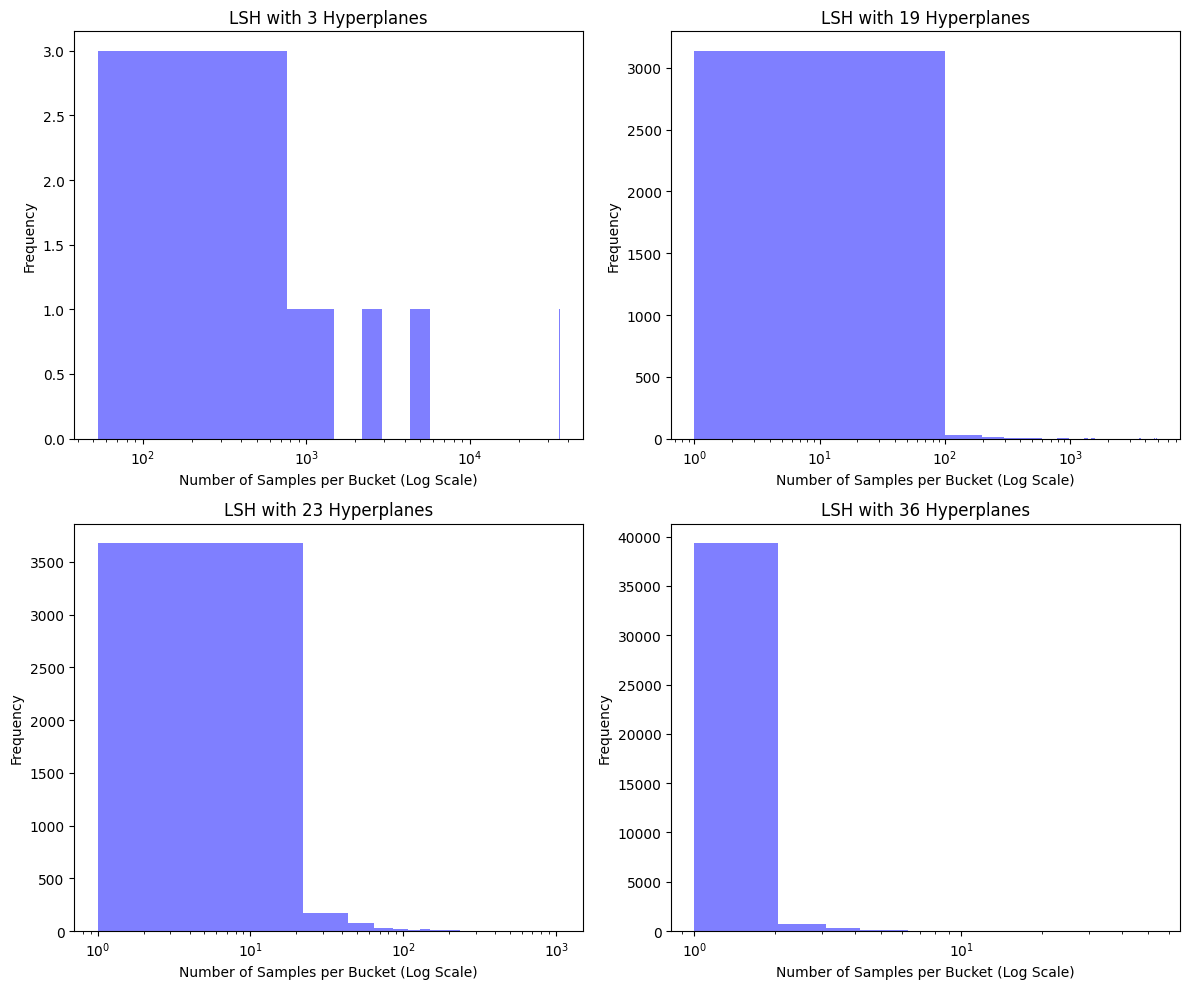

In [19]:

plane_counts = [3, 19, 23, 36]
fig, sub_axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, planes_count in enumerate(plane_counts):
    lsh_ref = LSH(num_planes=planes_count, vec_dimension=train_emb.shape[1])
    lsh_ref.fit(train_emb)
    bucket_data = lsh_ref.get_bucket_sizes()
    
    r, c = divmod(idx, 2)
    sub_axes[r, c].hist(bucket_data, bins=50, color='blue', alpha=0.5)
    sub_axes[r, c].set_xscale('log')
    sub_axes[r, c].set_xlabel("Number of Samples per Bucket (Log Scale)")
    sub_axes[r, c].set_ylabel("Frequency")
    sub_axes[r, c].set_title(f"LSH with {planes_count} Hyperplanes")

plt.tight_layout()
plt.show()

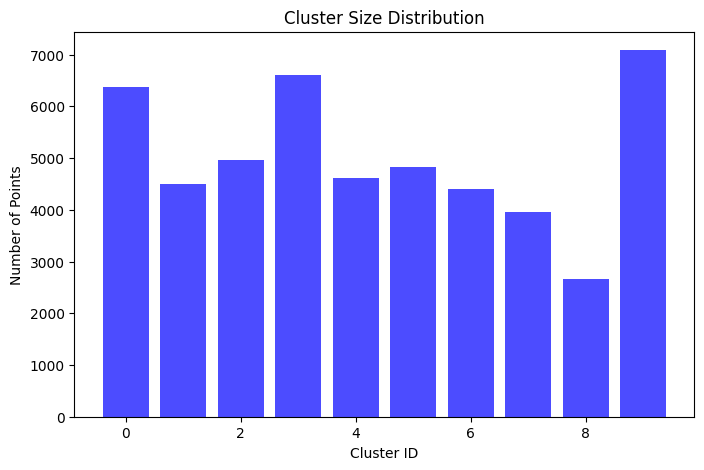

In [32]:
def build_ivf_index(training_vectors, training_labels, cluster_count=10):
    """
    Builds an Inverted File Index (IVF) using k-means clustering.
    
    Args:
        training_vectors (ndarray): Feature vectors for training.
        training_labels (ndarray): Corresponding labels for training data.
        cluster_count (int): Number of clusters to use in k-means.

    Returns:
        kmeans_ref (KMeans): Trained KMeans model.
        ivf_map (dict): Mapping of cluster ID to list of (vector, index, label).
    """
    kmeans_ref = KMeans(n_clusters=cluster_count, random_state=42, n_init=10)
    cluster_ids = kmeans_ref.fit_predict(training_vectors)

    # Create the inverted file index
    ivf_map = defaultdict(list)
    for idx, cid in enumerate(cluster_ids):
        ivf_map[cid].append((training_vectors[idx], idx, training_labels[idx]))

    # Plot cluster sizes
    plot_cluster_distribution(cluster_ids, cluster_count)

    return kmeans_ref, ivf_map


def plot_cluster_distribution(cluster_ids, cluster_count):
    """
    Plots the distribution of points across clusters.

    Args:
        cluster_ids (ndarray): Cluster assignments for each point.
        cluster_count (int): Number of clusters.
    """
    cluster_sizes = np.bincount(cluster_ids, minlength=cluster_count)
    plt.figure(figsize=(8, 5))
    plt.bar(range(cluster_count), cluster_sizes, color='blue', alpha=0.7)
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Points")
    plt.title("Cluster Size Distribution")
    plt.show()


def ivf_query(query_vec, kmeans_ref, ivf_map, probes=1, top_count=100):
    """
    Performs an IVF-based nearest neighbor search.

    Args:
        query_vec (ndarray): Query feature vector.
        kmeans_ref (KMeans): Pre-trained k-means model.
        ivf_map (dict): IVF mapping from cluster IDs to data points.
        probes (int): Number of clusters to search.
        top_count (int): Number of nearest neighbors to return.

    Returns:
        candidate_ids (list): Retrieved indices.
        candidate_lbls (list): Retrieved labels.
        comparisons (int): Total number of comparisons performed.
    """
    dist_array = cdist(query_vec.reshape(1, -1), kmeans_ref.cluster_centers_)
    nearest_cids = np.argsort(dist_array[0])[:probes]

    candidate_data, candidate_ids, candidate_lbls = [], [], []
    comparisons = 0

    # Gather candidates from nearest clusters
    for cid in nearest_cids:
        cluster_content = ivf_map.get(cid, [])
        comparisons += len(cluster_content)
        for embd, idx, lbl in cluster_content:
            candidate_data.append(embd)
            candidate_ids.append(idx)
            candidate_lbls.append(lbl)

    if candidate_data:
        candidate_data = np.array(candidate_data)
        distances = cdist(query_vec.reshape(1, -1), candidate_data)[0]
        best_idx = np.argsort(distances)[:top_count]
        return [candidate_ids[i] for i in best_idx], [candidate_lbls[i] for i in best_idx], comparisons

    return [], [], comparisons


def reciprocal_rank(eval_labels, true_label):
    """
    Computes the reciprocal rank of the first correct result.
    
    Args:
        eval_labels (list): List of retrieved labels.
        true_label (int/str): Ground truth label.

    Returns:
        float: Reciprocal rank score.
    """
    for rank, label in enumerate(eval_labels, start=1):
        if label == true_label:
            return 1 / rank
    return 0


def precision_at_k(eval_labels, true_label, k=100):
    """
    Computes precision@k.

    Args:
        eval_labels (list): List of retrieved labels.
        true_label (int/str): Ground truth label.
        k (int): Number of top retrieved elements to consider.

    Returns:
        float: Precision@k score.
    """
    return sum(1 for lbl in eval_labels[:k] if lbl == true_label) / k


def hit_rate(eval_labels, true_label):
    """
    Computes hit rate (binary 0 or 1).

    Args:
        eval_labels (list): List of retrieved labels.
        true_label (int/str): Ground truth label.

    Returns:
        int: 1 if true label is found in retrieved results, else 0.
    """
    return int(any(lbl == true_label for lbl in eval_labels))


def assess_ivf_retrieval(test_vectors, test_labels, kmeans_ref, ivf_map, probes=1, top_count=100):
    """
    Evaluates IVF retrieval performance using Mean Reciprocal Rank (MRR), Precision@K, and Hit Rate.

    Args:
        test_vectors (ndarray): Query vectors.
        test_labels (ndarray): Ground truth labels.
        kmeans_ref (KMeans): Pre-trained k-means model.
        ivf_map (dict): IVF mapping from cluster IDs to data points.
        probes (int): Number of clusters to search.
        top_count (int): Number of nearest neighbors to consider.

    Returns:
        dict: Evaluation metrics.
    """
    mrr_total, precision_total, hit_total, total_comparisons = 0, 0, 0, 0
    total_queries = len(test_vectors)

    for q_vec, true_label in zip(test_vectors, test_labels):
        retrieved_ids, retrieved_labels, comparisons = ivf_query(q_vec, kmeans_ref, ivf_map, probes, top_count)

        mrr_total += reciprocal_rank(retrieved_labels, true_label)
        precision_total += precision_at_k(retrieved_labels, true_label, top_count)
        hit_total += hit_rate(retrieved_labels, true_label)
        total_comparisons += comparisons

    return {
        "MRR": mrr_total / total_queries,
        "Precision": precision_total / total_queries,
        "Hit Rate": hit_total / total_queries,
        "<Comparisions>": total_comparisons / total_queries
    }


cluster_count = 10
kmeans_ref, ivf_index = build_ivf_index(train_emb, train_lbl, cluster_count)

In [34]:
probe_list = [3, 7]

for probe_count in probe_list:
    retrieval_stats = assess_ivf_retrieval(
        train_emb, 
        test_lbl, 
        kmeans_ref, 
        ivf_index, 
        probes=probe_count, 
        top_count=100
    )
    print(f"Avg Comparisons per Query is {retrieval_stats['<Comparisions>']:.2f}")
    print(f"Results for nprobe {probe_count}:")
    print(f"MRR is {retrieval_stats['MRR']:.4f}")
    print(f"Precision is {retrieval_stats['Precision']:.4f}")
    print(f"Hit Rate is {retrieval_stats['Hit Rate']:.4f}")
    print("--**--" * 10)

Avg Comparisons per Query is 3232.40
Results for nprobe 3:
MRR is 0.0236
Precision is 0.0199
Hit Rate is 0.0571
--**----**----**----**----**----**----**----**----**----**--
Avg Comparisons per Query is 7132.08
Results for nprobe 7:
MRR is 0.0237
Precision is 0.0199
Hit Rate is 0.0576
--**----**----**----**----**----**----**----**----**----**--


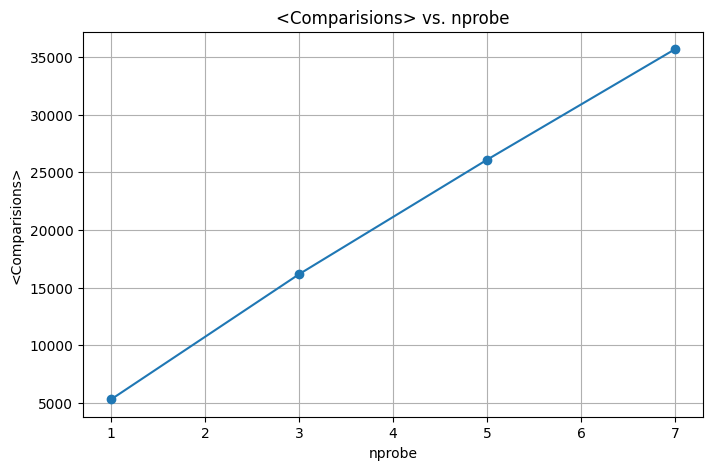

In [35]:
def plot_probe_comparisons(probe_list, comps_query):
    plt.figure(figsize=(8, 5))
    plt.plot(probe_list, comps_query, marker='o', linestyle='-')
    plt.xlabel("nprobe")
    plt.ylabel("<Comparisions>")
    plt.title("<Comparisions> vs. nprobe")
    plt.grid()
    plt.show()

probe_list = [1, 3, 5, 7]
comps_query = []

for probe_val in probe_list:
    stats = assess_ivf_retrieval(test_emb, test_lbl, kmeans_ref, ivf_index, probes=probe_val, top_count=100)
    comps_query.append(stats['<Comparisions>'])

plot_probe_comparisons(probe_list, comps_query)

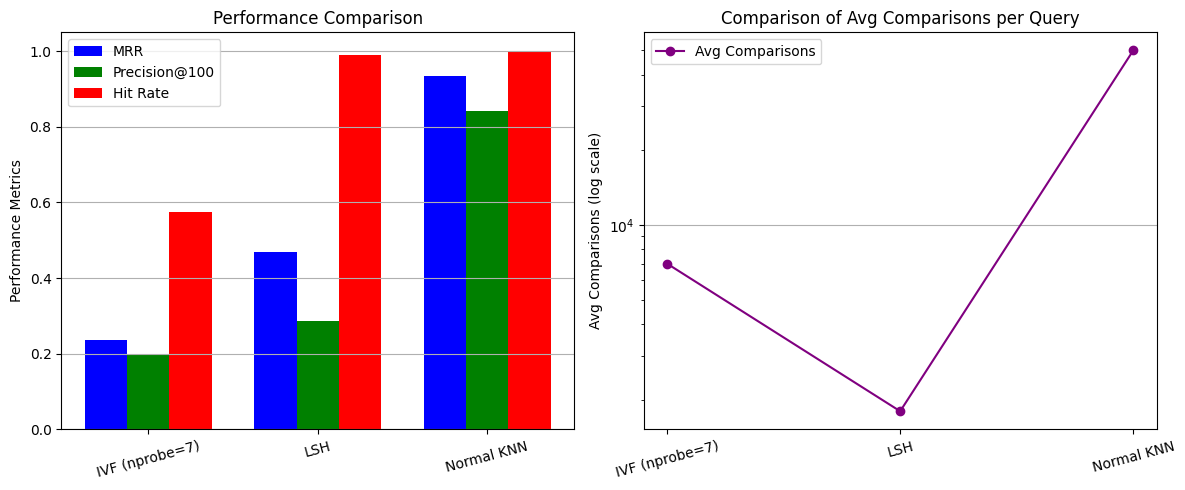

In [36]:
#Analysis
methods = ["IVF (nprobe=7)", "LSH", "Normal KNN"]
metrics = {
    "MRR": [ 0.237,0.4685, 0.9348],
    "Precision@100": [0.199, 0.2866, 0.8411],
    "Hit Rate": [0.576,0.9894, 0.9996],
    "Avg Comparisons": [ 7000, 1795, 50000]
}

x = np.arange(len(methods))  # X-axis positions

# Define bar width for grouped bars
bar_width = 0.25

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 1st subplot: Grouped Bar Chart for MRR, Precision, and Hit Rate
ax1.bar(x - bar_width, metrics["MRR"], width=bar_width, label="MRR", color='b')
ax1.bar(x, metrics["Precision@100"], width=bar_width, label="Precision@100", color='g')
ax1.bar(x + bar_width, metrics["Hit Rate"], width=bar_width, label="Hit Rate", color='r')

ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=15)
ax1.set_ylim(0, 1.05)
ax1.set_ylabel("Performance Metrics")
ax1.set_title("Performance Comparison")
ax1.legend()
ax1.grid(axis='y')

# 2nd subplot: Line Plot for Avg Comparisons
ax2.plot(x, metrics["Avg Comparisons"], marker='o', linestyle='-', color='purple', label="Avg Comparisons")
ax2.set_xticks(x)
ax2.set_xticklabels(methods, rotation=15)
ax2.set_yscale("log")  # Log scale for better visibility
ax2.set_ylabel("Avg Comparisons (log scale)")
ax2.set_title("Comparison of Avg Comparisons per Query")
ax2.grid(axis='y')
ax2.legend()

plt.tight_layout()
plt.show()